In [1]:
%matplotlib inline

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

# some default imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# we will use arviz for some of the plotting
import arviz as az

# import jax and set it up to use double precision
from jax import config
config.update("jax_enable_x64", True)

import numpyro
numpyro.set_host_device_count(4)
numpyro.set_platform('cpu')

from jax import numpy as jnp, random
from numpyro import sample, handlers
from numpyro.distributions import (
    Categorical,
    Dirichlet,
    ImproperUniform,
    Normal,
    OrderedLogistic,
    TransformedDistribution,
    constraints,
    transforms,
)
from numpyro.infer import MCMC, NUTS
from numpyro.infer.reparam import TransformReparam

# set plotting context
sns.set_context('notebook')
sns.set_palette('colorblind')

# Ordinal regression

Let's demonstrate a simple model of ordinal inference over a set of scores using _numpyro_. I'm going to follow closely the examples in the numpyro docs [here](https://num.pyro.ai/en/stable/tutorials/ordinal_regression.html), as well as Betancourt notes [here](https://betanalpha.github.io/assets/case_studies/ordinal_regression.html).

## Background

Let $Y$ be an ordinal variable (i.e., a variable that can only take one of a number of discrete, ordered values: $Y_0 < Y_1 < ... < Y_{K-1}$), for which we have a number of measurements (e.g., rankings from a survey of several respondents/judges). To get a posterior on the true value of $Y$, we will introduce an auxiliary latent variable $X$, which is defined over the reals ($X \in \mathbb{R}$). Instead of working directly in the discrete space of $Y$, we can model a latent distribution in the $X$ space, which is continuous and unbounded.

To do this, we need a mapping from $X$ to $Y$ or, rather, a discretization procedure that takes us from $X$ to $Y$. This can be achieved by partitioning the $X$ domain into $K$ segments defined by a series of $K+1$ _cut points_ $c_k$, with $c_0 = -\infty < c_1 < \dots < c_{K-1} < c_K = \infty$, so that probability mass within each $(c_k, c_{k+1})$ segment is assigned to $Y_k$.

With this setup, all we need is a prescription for the probability density on $X$, $p(X)$. Within reason, the specific choice doesn't matter because we can always counteract changes in the shape of this distribution by tweaking the cut points, so we can pick $p(X)$ for computational convenience. A common choice is a logistic PDF, given by
$$
p(x) = \frac{e^{-x}}{\left(1 + e^{-x}\right)^2} ~ ;
$$
the CDF of this PDF, i.e. $\Phi(x) = \int_\infty^x p(x') {\rm }dx'$, is the logistic function, namely
$$
\Phi(x) = \frac{e^{x}}{1+ e^{x}} ~ .
$$
This is an _ordinal logistic model_.

## Simple survey

Imagine we have a survey with `n_bins` ranked categories to choose from (e.g., "rank the quality of service from 0 to 5"), and that we have received `n_resp` responses. Assuming there is a truth that the set of responses represent imperfectly, what is the "true" score for this question? We will answer this with ordinal regression, following the models cited above.

In [4]:
# # create some data based on Betancourt's example for sanity checking
# scores = np.array([2, 4, 13, 22, 9])

# n_bins = len(scores)
# n_resp = sum(scores)

Create some data based on the numpyro example for sanity checking. We can generate categorical data using the `Categorical` class in numpro; this will produce categorical draws for a number of bins, with probabilities specified by either a `probs` argument or a `logits` argument, which should be vectors with the same length as the number of bins. Recall that the logit is just an equivalent way of specifying the probability $p$, and it's given by
$$
l \equiv {\rm logit}(p) = \ln\left(\frac{p}{1-p}\right) ;
$$ 
this corresponds to the log odds, i.e., the logarithm of the odds $p /( 1-p)$. The transformation from a set of logits to probabilities is obtained through the _softmax function_,
$$
p_i(\{l_0, \dots , l_{K-1}\}) = \frac{e^l_i}{\sum_{k=0}^{K-1} e^{l_k}} ~ ,
$$
which guarantees that the probabilities are normalized correctly.

In [ ]:
simkeys = random.split(random.PRNGKey(1), 2)

n_resp = 50
n_bins = 3

# the Categorical class will draw samples from a categorical distribution
# defined over a set of bins, with probabilities given by the logits argument
Y = Categorical(logits=jnp.zeros(n_bins)).sample(simkeys[0], sample_shape=(n_resp,))

# create corresponding noisy observations in the latent space of X by sampling
# from a Normal distribution
X = Normal().sample(simkeys[1], sample_shape=(n_resp,))
X += Y

print("value counts of Y:")
df = pd.DataFrame({"X": X, "Y": Y})
print(df.Y.value_counts())

for i in range(n_bins):
    print(f"mean(X) for Y == {i}: {X[jnp.where(Y==i)].mean():.3f}")

value counts of Y:
Y
0    19
2    17
1    14
Name: count, dtype: int64
mean(X) for Y == 0: 0.462
mean(X) for Y == 1: 1.077
mean(X) for Y == 2: 1.856


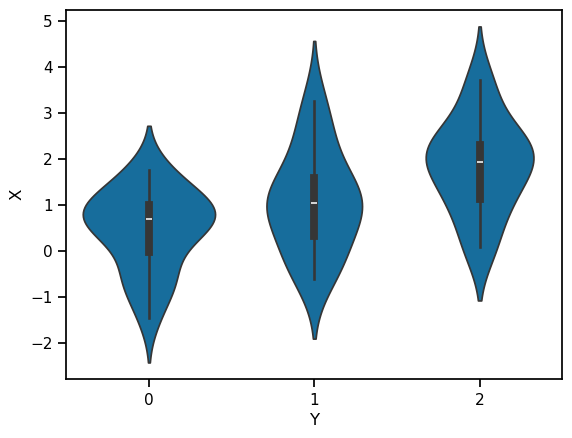

In [5]:
sns.violinplot(x="Y", y="X", data=df);

In [54]:
# df = pd.read_csv('ranking_data_anon.csv', index_col=None)
# df[df['Category'] == 'Clarity']['Candidate-0']

In [57]:
def model1(X, Y, nclasses=3):
    b_X_eta = sample("b_X_eta", Normal(0, 5))
    c_y = sample(
        "c_y",
        ImproperUniform(
            support=constraints.ordered_vector,
            batch_shape=(),
            event_shape=(nclasses - 1,),
        ),
    )
    with numpyro.plate("obs", X.shape[0]):
        eta = X * b_X_eta
        sample("Y", OrderedLogistic(eta, c_y), obs=Y)


mcmc_key = random.PRNGKey(1234)
kernel = NUTS(model1)
mcmc = MCMC(kernel, num_warmup=250, num_samples=750)
mcmc.run(mcmc_key, X, Y, n_bins)
mcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:01<00:00, 585.00it/s, 7 steps of size 4.27e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   b_X_eta      1.07      0.27      1.06      0.63      1.50    419.55      1.00
    c_y[0]      0.48      0.38      0.47     -0.15      1.06    459.36      1.00
    c_y[1]      2.06      0.47      2.02      1.22      2.73    447.09      1.00

Number of divergences: 0
